[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Azie88/Coachella-Tweet-Sentiment-Analysis/blob/main/Sentiment_Analysis_Coachella.ipynb)


# Sentiment Analysis Using Colab and Huggingface

What's Deep Learning? It is machine learning based on artificial neural networks in which multiple layers of processing are used to extract progressively higher level features from data.

In this project, we will fine-tune a pre-trained Deep Learning model from HuggingFace on a new dataset ([Coachella 2015 tweet sentiment](https://https://www.kaggle.com/datasets/thedevastator/twitter-sentiment-analysis-coachella-festival)) to adapt the model to our sentiment analysis task, then create an app to use the model and deploy the app on the HuggingFace platform.

## Install Libraries and Packages

In [ ]:
!pip install datasets
!pip install evaluate
!pip install transformers[torch]
!pip install accelerate -U

## Import Libraries and Packages

In [ ]:
#System and data handling
import os
import re
import warnings
import pandas as pd
import numpy as np

#Data Analysis & Preparation
from evaluate import load
from collections import Counter
from datasets import load_dataset

#Scikit-Learn
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight

#Google Drive
from google.colab import drive

#Visualization
import matplotlib.pyplot as plt
from wordcloud import WordCloud

#Transformers
from transformers import AutoTokenizer, AutoConfig, AutoModelForSequenceClassification, TrainingArguments, Trainer, DataCollatorWithPadding, TFAutoModelForSequenceClassification

#Scores
from scipy.special import softmax

# Deep learning
import torch
from torch import nn

#Huggingface
from huggingface_hub import notebook_login

## Setup

In [ ]:
# Set a fixed random seed for PyTorch on CPU
torch.manual_seed(42)

# Control the seed for individual GPU operations (optional)
if torch.cuda.is_available:
  torch.backends.cudnn.deterministic = True
  torch.backends.cudnn.benchmark = False
  torch.cuda.manual_seed_all(42)


In [ ]:
# Set CUDA_LAUNCH_BLOCKING for debugging
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

## Connect to Google Drive & Load Dataset

In [ ]:
# Connect to your google drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Sentiment Analysis NLP/Dataset/Coachella-2015-2-DFE.csv', encoding='latin-1')

## Data Understanding

In [ ]:
#look at first 5 rows in train data
df.head()

,coachella_sentiment,coachella_yn,name,retweet_count,text,tweet_coord,tweet_created,tweet_id,tweet_location,user_timezone
0,positive,yes,kokombil,0,#Coachella2015 tickets selling out in less tha...,"[0.0, 0.0]",1/7/15 15:02,5.529630e+17,NaN,Quito
1,positive,yes,MisssTaraaa10,2,RT @sudsybuddy: WAIT THIS IS ABSOLUTE FIRE _ÙÓ...,NaN,1/7/15 15:02,5.529630e+17,united states,NaN
2,positive,yes,NMcCracken805,0,#Coachella2015 #VIP passes secured! See you th...,NaN,1/7/15 15:01,5.529630e+17,"Costa Mesa, CA",NaN
3,positive,yes,wxpnfm,1,PhillyÛªs @warondrugsjams will play #Coachell...,NaN,1/7/15 15:01,5.529630e+17,"Philadelphia, PA and Worldwide",Quito
4,positive,yes,Caesears,0,If briana and her mom out to #Coachella2015 i...,NaN,1/7/15 15:00,5.529630e+17,NaN,NaN


In [ ]:
df.shape

(3846, 10)

In [ ]:
df.dtypes

,0
coachella_sentiment,object
coachella_yn,object
name,object
retweet_count,int64
text,object
tweet_coord,object
tweet_created,object
tweet_id,float64
tweet_location,object
user_timezone,object


In [ ]:
df.isna().sum()

,0
coachella_sentiment,0
coachella_yn,0
name,0
retweet_count,0
text,0
tweet_coord,3604
tweet_created,0
tweet_id,0
tweet_location,1170
user_timezone,983


In [ ]:
df.coachella_sentiment.value_counts()

,count
coachella_sentiment,
positive,2283
neutral,928
negative,553
cant tell,82


In [ ]:
df.text.sample(10)

,text
937,ÛÏ@LL_COOL_LJ: #Coachella2015 Huh? _Ù÷ö_Ù÷ö_Ù...
1985,i just wanna see the queen on coachella VANESS...
3201,Iron Maiden to headline Coachella 2015 #Coache...
808,RT @ceearahk: SOOOO excited for #Coachella2015...
3164,Get the full @coachella 2015 lineup and detail...
2683,RT @crisdacat: Check out the #Coachella2015 li...
3323,Suck my dick #coachella2015 by flyydoggsexmach...
892,wtf how can there be so many beautiful people ...
1399,Milky Chance is going to be at #Coachella2015 ...
3444,So far my opinion that is one shitty line up #...


## Data Preparation

1. Delete all unnecessary columns
2. Rename *coachella_sentiment* column to *labels*
3. Remove rows with *'can't tell'* sentiment values.
4. Clean *text* column of Twitter Handles, HTML characters, URLs and other non alphabetic characters. Text is inconsistent and may affect model performance.
5.  Map sentiment labels to numerical values.



In [ ]:
#drop unnecessary columns
df = df.drop(columns=['coachella_yn', 'name', 'retweet_count', 'tweet_coord', 'tweet_id', 'user_timezone','tweet_location', 'tweet_created'])
df.head(10)

,coachella_sentiment,text
0,positive,#Coachella2015 tickets selling out in less tha...
1,positive,RT @sudsybuddy: WAIT THIS IS ABSOLUTE FIRE _ÙÓ...
2,positive,#Coachella2015 #VIP passes secured! See you th...
3,positive,PhillyÛªs @warondrugsjams will play #Coachell...
4,positive,If briana and her mom out to #Coachella2015 i...
5,positive,West side is the best side!\n#west #coas #Coac...
6,positive,Coachella tickets are now sold out _Ù÷_ &amp; ...
7,positive,#Coachella2015 I absolutely can NOT wait. This...
8,positive,If someone got me to Coachella if be your frie...
9,positive,RT @brownjenjen:  Õ http://t.co/mxCREvIlGP 71...


In [ ]:
df.rename(columns={'coachella_sentiment': 'label'}, inplace=True)

In [ ]:
#Remove rows with 'can't tell' sentiment values
df = df[df['label'] != 'cant tell']

In [ ]:
df.label.value_counts()

,count
label,
positive,2283
neutral,928
negative,553


In [ ]:
def clean_text(text):
    # Convert text to lower case
    text = text.lower()

    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)

    # Remove tweet mentions
    text = re.sub(r'<user>', '', text)
    text = re.sub(r'<url>', '', text)

    # Remove special characters
    text = re.sub(r'[^a-zA-Z\s]', '', text)

    # Replace all whitespace characters with a single space
    text = re.sub(r'\s+', ' ', text)

    # Remove leading and trailing whitespace
    text = text.strip()

    return text

In [ ]:
# Apply the clean_text function to the 'text' column
df['text'] = df.text.apply(clean_text)

In [ ]:
df.sample(10)

,label,text
2603,neutral,tomorrow can either be my favorite day or my m...
2994,neutral,rt langmarmendoza lioneesssssss rahknee youve ...
1320,positive,coachella lineup is legit including georgeezra...
1897,positive,i knew it this year was definitely going to be...
54,positive,if anyone has an extra car camping ticket hit ...
1354,positive,becausecoachella coachella coachella valley mu...
2829,neutral,my coachella lineup
2055,positive,im so exited to see you at coachella angusjuli...
3233,negative,fuck everyone who waiting in that lobby page m...
1315,positive,coachella line up is mad bruh


In [ ]:
sentiment_mapping = {'positive': 1, 'neutral': 0, 'negative': -1}

# Map the sentiment labels to numerical values
df['label'] = df['label'].map(sentiment_mapping)

In [ ]:
df.label.value_counts()

,count
label,
1,2283
0,928
-1,553


## Exploratory Data Analysis

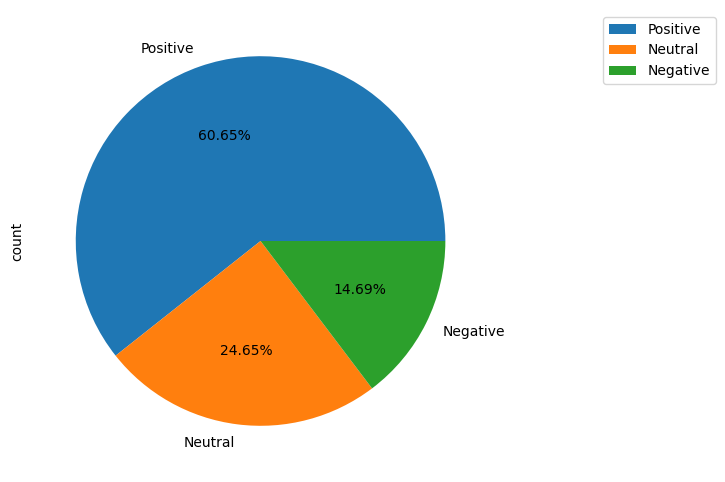

In [ ]:
# pie chart wth 'labels' column
plt.figure(figsize=(6,6))
explode=0.1,0
df.label.value_counts().plot.pie(autopct='%1.2f%%',labels=['Positive','Neutral','Negative'])
plt.legend(bbox_to_anchor=(1.5,1))
plt.show()

(np.float64(-0.5), np.float64(399.5), np.float64(199.5), np.float64(-0.5))

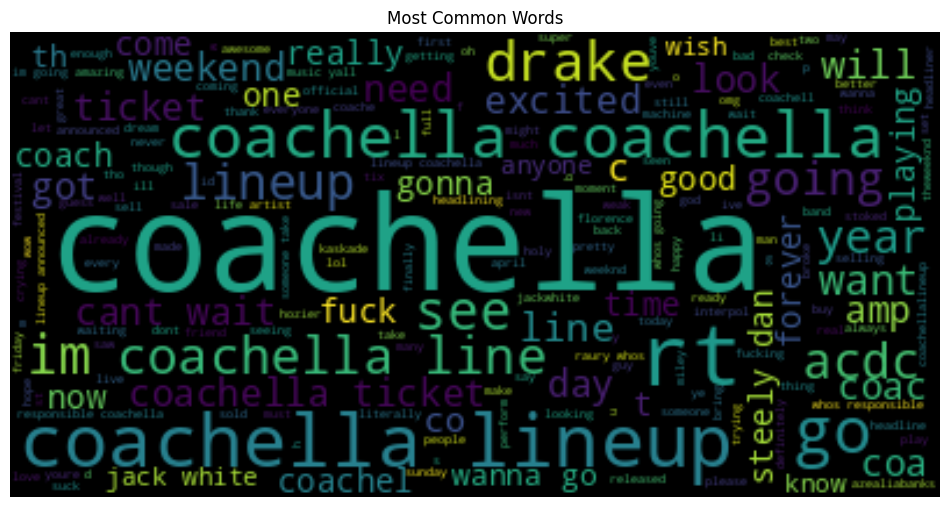

In [ ]:
# Word Cloud
all_data = df['text'].to_string()
wordcloud = WordCloud().generate(all_data)
plt.figure(figsize=(12,8))
plt.imshow(wordcloud,interpolation='bilinear')
plt.title('Most Common Words')
plt.axis("off")

In [ ]:
# Word Count - Top 20 most common words
temp_list = df['text'].apply(lambda x:str(x).split())
top = Counter([item for sublist in temp_list for item in sublist])
temp = pd.DataFrame(top.most_common(20))
temp.columns = ['Common_words','count']
temp.style.background_gradient(cmap='Blues')

,Common_words,count
0,coachella,4854
1,to,1356
2,the,1298
3,i,955
4,lineup,725
5,is,721
6,and,573
7,rt,518
8,for,513
9,this,426


In [ ]:
text_lengths = df['text'].str.split().str.len()
text_lengths.value_counts().sort_values(ascending=False)

,count
text,
7,310
6,263
9,262
5,256
10,246
8,243
12,212
13,210
11,201


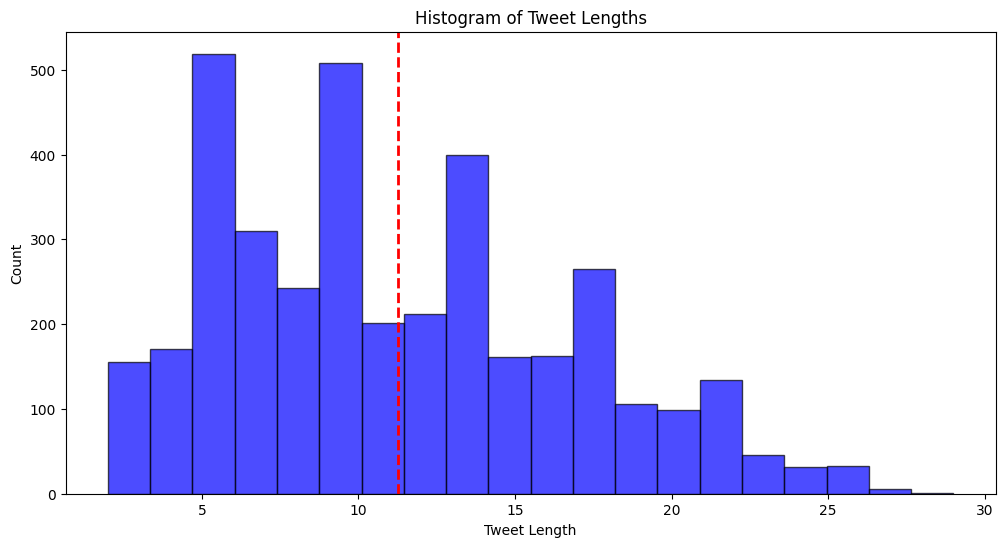

In [ ]:
# Calculate the average
average_length = np.mean(text_lengths)

# Create a figure and axis
fig, ax = plt.subplots(figsize=(12, 6))

# Using plt.hist to create a histogram with Matplotlib
ax.hist(text_lengths, bins=20, color="blue", edgecolor="black", alpha=0.7)

# Add average line
ax.axvline(average_length, color='red', linestyle='dashed', linewidth=2, label=f'Average: {average_length:.2f}')

ax.set_title('Histogram of Tweet Lengths')
ax.set_xlabel('Tweet Length')
ax.set_ylabel('Count')

# Display the plot
plt.show()

## Train Test Split

In [ ]:
# Split the train data => {train, eval}
train, eval = train_test_split(df, test_size=0.2, random_state=42, stratify=df['label'])

In [ ]:
train.head()

,label,text
3469,-1,i wish incubus or sonsofthesea would have been...
2956,0,eric this is hilareous haha thatericalper this...
3584,-1,gotta get my abs back for coachella but i love...
3296,-1,i hope it rains during drakes coachella set so...
1011,1,omg the coachella lineup soexcited


In [ ]:
eval.head()

,label,text
1576,1,everyone is talking about the nflplayoffs and ...
3577,-1,ok back to oogling and crying at this lineup t...
726,1,bring it coachella have my artist pass amp roo...
3197,0,coachella lineup preview coachella coachella c...
1,1,rt sudsybuddy wait this is absolute fire coach...


In [ ]:
print(f"new dataframe shapes: train is {train.shape}, eval is {eval.shape}")

new dataframe shapes: train is (3011, 2), eval is (753, 2)


In [ ]:
# Save split subsets
train.to_csv("/content/drive/MyDrive/Sentiment Analysis NLP/Dataset/train_subset.csv", index=False)
eval.to_csv("/content/drive/MyDrive/Sentiment Analysis NLP/Dataset/eval_subset.csv", index=False)

In [ ]:
# Load split subsets

dataset = load_dataset('csv',
                        data_files={'train': '/content/drive/MyDrive/Sentiment Analysis NLP/Dataset/train_subset.csv',
                        'eval': '/content/drive/MyDrive/Sentiment Analysis NLP/Dataset/eval_subset.csv'}, encoding = "ISO-8859-1")

Generating train split: 0 examples [00:00, ? examples/s]

Generating eval split: 0 examples [00:00, ? examples/s]

## Model Training and Fine Tuning

In [ ]:
#login to huggingface with access token

notebook_login()

In [ ]:
warnings.filterwarnings("ignore", category=FutureWarning)

nlp = f"cardiffnlp/twitter-roberta-base-sentiment-latest"
tokenizer = AutoTokenizer.from_pretrained(nlp)

config.json:   0%|          | 0.00/929 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

## Label and Text Processing

In [ ]:
def transform_labels(label):

    label = label['label']
    num = 0
    if label == -1: #'Negative'
        num = 0
    elif label == 0: #'Neutral'
        num = 1
    elif label == 1: #'Positive'
        num = 2

    return {'labels': num}

In [ ]:
# Function to tokenize data

def tokenize_data(example):
    return tokenizer(example['text'], padding=True, max_length = 'max_length')

In [ ]:
# Change the tweets to tokens that the model can use
dataset = dataset.map(tokenize_data, batched=True)

# Transform	labels and remove the useless columns
remove_columns = ['label', 'text']
dataset = dataset.map(transform_labels, remove_columns=remove_columns)

Map:   0%|          | 0/3011 [00:00<?, ? examples/s]

/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:2718: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(


Map:   0%|          | 0/753 [00:00<?, ? examples/s]

Map:   0%|          | 0/3011 [00:00<?, ? examples/s]

Map:   0%|          | 0/753 [00:00<?, ? examples/s]

In [ ]:
dataset

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 3011
    })
    eval: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 753
    })
})

### Balancing Target Classes

Since our target has imbalanced class weights (positive, neutral and negative dont have an equal number of samples), we want to give more weight to underrepresented classes and give less weight to classes with more samples.

In [ ]:
# Define the labels
labels = dataset['train']['labels']

# Apply the compute class weight function to calculate the class weight
class_weights = compute_class_weight('balanced', classes=np.unique(labels), y=labels)

The `balanced` option in compute_class_weight will calculate weights such that the classes are balanced.

In [ ]:
# Preview class weights
class_weights, np.unique(labels)

(array([2.26561324, 1.35265049, 0.54965316]), array([0, 1, 2]))

### Initialize pre-trained model

In [ ]:
# Define an instance of the pre-trained model with the number of labels
model = AutoModelForSequenceClassification.from_pretrained(nlp, num_labels=3)

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


pytorch_model.bin:   0%|          | 0.00/501M [00:00<?, ?B/s]

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
# Configure the training parameters

training_args = TrainingArguments("Coachella_sentiment_analysis_roberta",
    num_train_epochs=5, # the number of times the model will repeat the training loop over the dataset
    load_best_model_at_end=True,
    eval_strategy='epoch',
    save_strategy='epoch',
)

In [ ]:
# evaluation metrics
metric = load("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

FileNotFoundError: Couldn't find a module script at /content/accuracy/accuracy.py. Module 'accuracy' doesn't exist on the Hugging Face Hub either.

In [ ]:
# Instantiate the training and validation sets with random state of 10
train_dataset = dataset['train'].shuffle(seed=10)
eval_dataset = dataset['eval'].shuffle(seed=10)

In [ ]:
# Convert train data to PyTorch tensors to speed up training and add padding
data_collator = DataCollatorWithPadding(tokenizer=tokenizer,padding=True, max_length='max_length', return_tensors='pt')

In [ ]:
# Define Custom Trainer | Modify loss function and assign computed weights
class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):
        labels = inputs.get("labels")
        # forward pass
        outputs = model(**inputs)
        logits = outputs.get("logits")

        # Ensure logits and labels have compatible shapes
        assert logits.shape[1] == self.model.config.num_labels, f"Logits shape {logits.shape} does not match number of labels {self.model.config.num_labels}"
        assert labels.max() < self.model.config.num_labels, f"Labels contain values outside the valid range: {labels}"

        # Ensure labels are of integer type
        assert labels.dtype == torch.long, f"Labels must be of type torch.long, but got {labels.dtype}"

        class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32).to(model.device)

        # Compute custom loss
        loss_fct = nn.CrossEntropyLoss(weight=class_weights_tensor)
        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))
        return (loss, outputs) if return_outputs else loss

In [ ]:
# Instantiate the trainer for training
c_trainer = CustomTrainer(
                  model=model,
                  args=training_args,
                  train_dataset=train_dataset,
                  eval_dataset=eval_dataset,
                  tokenizer = tokenizer,
                  compute_metrics=compute_metrics,
)

In [ ]:
# Launch the learning process: training
c_trainer.train()

In [ ]:
# Launch the final evaluation
c_trainer.evaluate()

In [ ]:
# Push model and tokenizer to HF Hub
model.push_to_hub("Azie88/Coachella_sentiment_analysis_roberta")
tokenizer.push_to_hub("Azie88/Coachella_sentiment_analysis_roberta")
dataset.push_to_hub("Azie88/Coachella_sentiment_analysis_roberta")

This notebook is inspired by an article: [Fine-Tuning Bert for Tweets Classification ft. Hugging Face](https://medium.com/mlearning-ai/fine-tuning-bert-for-tweets-classification-ft-hugging-face-8afebadd5dbf)

## Inference
Let's test out our model with with some sample text

In [ ]:
model_path = f"Azie88/Coachella_sentiment_analysis_roberta"

tokenizer = AutoTokenizer.from_pretrained(model_path)
config = AutoConfig.from_pretrained(model_path)
model = AutoModelForSequenceClassification.from_pretrained(model_path)

In [ ]:
# Preprocess text (username and link placeholders)
def preprocess(text):
    new_text = []
    for t in text.split(" "):
        t = '@user' if t.startswith('@') and len(t) > 1 else t
        t = 'http' if t.startswith('http') else t
        new_text.append(t)
    return " ".join(new_text)

In [ ]:
# Input preprocessing
text = "that saturday lineup is fire, except for Jack White"
text = preprocess(text)

In [ ]:
# PyTorch-based models
encoded_input = tokenizer(text, return_tensors='pt')
output = model(**encoded_input)
scores = output[0][0].detach().numpy()
scores = softmax(scores)

In [ ]:
print("Scores:", scores)
print("id2label Dictionary:", config.id2label)

In [ ]:
config.id2label = {0: 'NEGATIVE', 1: 'NEUTRAL', 2: 'POSITIVE'}

In [ ]:
# Print labels and scores
ranking = np.argsort(scores)
ranking = ranking[::-1]
for i in range(scores.shape[0]):
    l = config.id2label[ranking[i]]
    s = scores[ranking[i]]
    print(f"{i+1}) {l} {np.round(float(s), 4)}")